=== ANÁLISE DE HÜCKEL PARA A OXEPINA ===

### ENERGIAS DOS ORBITAIS MOLECULARES ###
OM    Energia (eV)    Ocupação    Tipo
----------------------------------------
 1      -6.563       2.00        ocupado
 2      -4.156       2.00        ocupado
 3      -3.208       2.00        ocupado
 4      -0.644       2.00        HOMO
 5       1.433       0.00        LUMO
 6       3.613       0.00        virtual
 7       4.524       0.00        virtual

Gap HOMO-LUMO: 2.077 eV

### POPULAÇÕES E CARGAS π ###
Átomo  Elemento  População  Carga
-----------------------------------
 1     O        1.901     0.099
 2     C        0.933     0.067
 3     C        1.095    -0.095
 4     C        1.021    -0.021
 5     C        1.021    -0.021
 6     C        1.095    -0.095
 7     C        0.933     0.067

População π total: 8.000 (deve ser 8)
Carga π total: 0.000 (deve ser 0.000)

### ORDENS DE LIGAÇÃO π ###
Ligação      Ordem de Ligação
------------------------------
1-7       0.213
1-2       0.213
2-3   

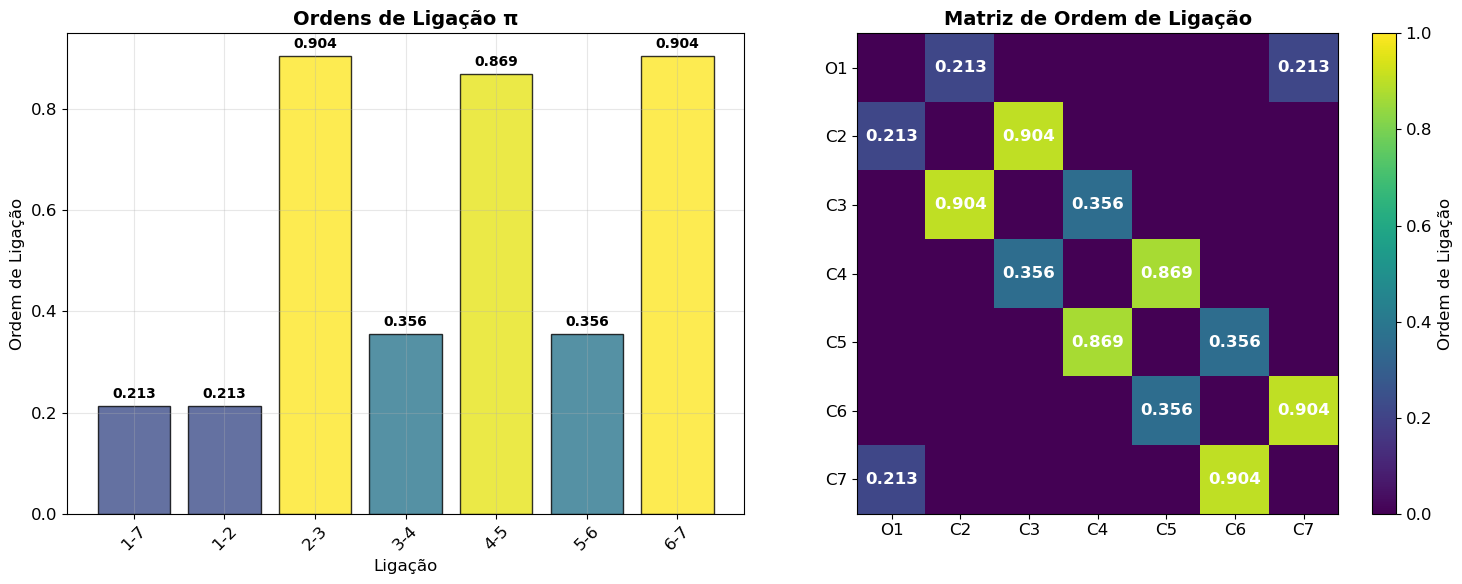

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import json

# Configura os parâmetros dos gráficos
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

class OxepineHuckelAnalysis:
    """Análise completa de Hückel para a Oxepina"""

    def __init__(self):
        # Parâmetros do Método de Hückel (MH)
        self.alpha_0 = 0.0  # eV
        self.beta_0 = -2.5  # eV

        # Parâmetros para heteroátomos
        self.h_O = 2.0  # oxigênio tipo furano
        self.h_C = 0.0  # carbono

        # Parâmetros de ligação
        self.k_CO = 0.8   # C-O simples
        self.k_CC_single = 0.9  # C-C simples
        self.k_CC_double = 1.1  # C=C dupla

        # Configuração da molécula
        self.n_atoms = 7
        self.elements = ['O', 'C', 'C', 'C', 'C', 'C', 'C']
        self.n_electrons = 8  # 2(O) + 6(C)

        # Conectividade (indexação baseada em 1 convertida para base 0)
        self.bonds = [
            (0, 6, self.k_CO),      # O1-C7
            (0, 1, self.k_CO),      # O1-C2
            (1, 2, self.k_CC_double), # C2=C3
            (2, 3, self.k_CC_single), # C3-C4
            (3, 4, self.k_CC_double), # C4=C5
            (4, 5, self.k_CC_single), # C5-C6
            (5, 6, self.k_CC_double)  # C6=C7
        ]

    def build_hamiltonian(self):
        """Constrói a matriz Hamiltoniana de Hückel"""
        H = np.zeros((self.n_atoms, self.n_atoms))

        # Energias on-site (diagonal)
        for i in range(self.n_atoms):
            if self.elements[i] == 'O':
                H[i, i] = self.alpha_0 + self.h_O * self.beta_0
            else:  # Carbono
                H[i, i] = self.alpha_0 + self.h_C * self.beta_0

        # Integrais de ressonância (fora da diagonal)
        for i, j, k_ij in self.bonds:
            beta_ij = k_ij * self.beta_0
            H[i, j] = beta_ij
            H[j, i] = beta_ij  # Simétrica

        return H

    def solve_eigenvalue_problem(self, H):
        """Resolve para obter as energias e os coeficientes dos OMs"""
        # Usa scipy.linalg.eigh para matrizes simétricas
        eigenvalues, eigenvectors = eigh(H)

        # Ordena por energia (crescente)
        idx = np.argsort(eigenvalues)
        energies = eigenvalues[idx]
        coefficients = eigenvectors[:, idx]

        return energies, coefficients

    def fill_electrons(self, energies):
        """Determina a ocupação eletrônica"""
        n_occ = self.n_electrons // 2  # Camada fechada

        homo_idx = n_occ - 1
        lumo_idx = n_occ

        homo_energy = energies[homo_idx]
        lumo_energy = energies[lumo_idx] if lumo_idx < len(energies) else None
        gap = lumo_energy - homo_energy if lumo_energy is not None else None

        return n_occ, homo_idx, lumo_idx, homo_energy, lumo_energy, gap

    def compute_density_matrix(self, coefficients, n_occ):
        """Calcula a matriz de densidade P"""
        P = np.zeros((self.n_atoms, self.n_atoms))

        # Soma sobre os orbitais ocupados
        for m in range(n_occ):
            for i in range(self.n_atoms):
                for j in range(self.n_atoms):
                    P[i, j] += 2 * coefficients[i, m] * coefficients[j, m]

        return P

    def compute_populations_and_charges(self, P):
        """Calcula as populações e cargas π"""
        populations = np.diag(P)

        # Elétrons π de referência para o cálculo da carga
        ref_electrons = [2 if el == 'O' else 1 for el in self.elements]
        charges = [ref - pop for ref, pop in zip(ref_electrons, populations)]

        return populations, charges

    def compute_bond_orders(self, P):
        """Calcula as ordens de ligação π"""
        bond_orders = {}

        for i, j, k_ij in self.bonds:
            bond_orders[(i+1, j+1)] = P[i, j]  # Converte para indexação baseada em 1

        return bond_orders

    def analyze(self):
        """Executa a análise de Hückel completa"""
        print("=== ANÁLISE DE HÜCKEL PARA A OXEPINA ===\n")

        # Constrói e resolve
        H = self.build_hamiltonian()
        energies, coefficients = self.solve_eigenvalue_problem(H)

        # Preenchimento eletrônico
        n_occ, homo_idx, lumo_idx, homo_energy, lumo_energy, gap = self.fill_electrons(energies)

        # Matriz de densidade e quantidades derivadas
        P = self.compute_density_matrix(coefficients, n_occ)
        populations, charges = self.compute_populations_and_charges(P)
        bond_orders = self.compute_bond_orders(P)

        # Armazena os resultados
        self.results = {
            'H': H,
            'energies': energies,
            'coefficients': coefficients,
            'P': P,
            'n_occ': n_occ,
            'homo_idx': homo_idx,
            'lumo_idx': lumo_idx,
            'homo_energy': homo_energy,
            'lumo_energy': lumo_energy,
            'gap': gap,
            'populations': populations,
            'charges': charges,
            'bond_orders': bond_orders
        }

        return self.results

    def print_results(self):
        """Imprime os resultados formatados"""
        r = self.results

        print("### ENERGIAS DOS ORBITAIS MOLECULARES ###")
        print("OM    Energia (eV)    Ocupação    Tipo")
        print("-" * 40)

        for i, E in enumerate(r['energies']):
            if i < r['n_occ']:
                occ = "2.00"
                mo_type = "HOMO" if i == r['homo_idx'] else "ocupado"
            else:
                occ = "0.00"
                mo_type = "LUMO" if i == r['lumo_idx'] else "virtual"

            print(f"{i+1:2d}    {E:8.3f}       {occ}        {mo_type}")

        print(f"\nGap HOMO-LUMO: {r['gap']:.3f} eV\n")

        print("### POPULAÇÕES E CARGAS π ###")
        print("Átomo  Elemento  População  Carga")
        print("-" * 35)

        for i in range(self.n_atoms):
            print(f"{i+1:2d}    {self.elements[i]:>2s}       {r['populations'][i]:6.3f}    {r['charges'][i]:6.3f}")

        # Validação
        total_pop = sum(r['populations'])
        total_charge = sum(r['charges'])
        print(f"\nPopulação π total: {total_pop:.3f} (deve ser {self.n_electrons})")
        print(f"Carga π total: {total_charge:.3f} (deve ser 0.000)\n")

        print("### ORDENS DE LIGAÇÃO π ###")
        print("Ligação      Ordem de Ligação")
        print("-" * 30)

        for bond, order in r['bond_orders'].items():
            print(f"{bond[0]}-{bond[1]}       {order:.3f}")

    def plot_bond_orders_heatmap(self):
        """Cria a visualização das ordens de ligação"""
        r = self.results
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Gráfico de barras das ordens de ligação
        bonds = list(r['bond_orders'].keys())
        orders = list(r['bond_orders'].values())
        bond_labels = [f"{b[0]}-{b[1]}" for b in bonds]
        
        colors = plt.cm.viridis([o/max(orders) for o in orders])
        bars = ax1.bar(bond_labels, orders, color=colors, alpha=0.8, edgecolor='black')
        ax1.set_title('Ordens de Ligação π', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Ordem de Ligação', fontsize=12)
        ax1.set_xlabel('Ligação', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45)
        
        # Adiciona os valores das ordens de ligação
        for bar, order in zip(bars, orders):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{order:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        
        # Mapa de calor da matriz completa de ordens de ligação
        bond_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for (i, j), order in r['bond_orders'].items():
            bond_matrix[i-1, j-1] = order
            bond_matrix[j-1, i-1] = order  # Simétrica
        
        im = ax2.imshow(bond_matrix, cmap='viridis', vmin=0, vmax=1)
        ax2.set_title('Matriz de Ordem de Ligação', fontsize=14, fontweight='bold')
        
        # Adiciona os rótulos dos átomos
        atom_labels = [f"{self.elements[i]}{i+1}" for i in range(self.n_atoms)]
        ax2.set_xticks(range(self.n_atoms))
        ax2.set_yticks(range(self.n_atoms))
        ax2.set_xticklabels(atom_labels)
        ax2.set_yticklabels(atom_labels)
        
        # Adiciona a barra de cores
        cbar = plt.colorbar(im, ax=ax2)
        cbar.set_label('Ordem de Ligação', fontsize=12)
        
        # Adiciona as anotações de texto
        for i in range(self.n_atoms):
            for j in range(self.n_atoms):
                if bond_matrix[i, j] > 0.01:
                    ax2.text(j, i, f'{bond_matrix[i, j]:.3f}', 
                            ha='center', va='center', color='white', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def plot_populations_and_charges(self):
        """Plota as populações e cargas π"""
        r = self.results
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        atoms = [f"{self.elements[i]}{i+1}" for i in range(self.n_atoms)]
        
        # Populações π
        colors1 = ['orange' if self.elements[i] == 'O' else 'lightblue' for i in range(self.n_atoms)]
        bars1 = ax1.bar(atoms, r['populations'], color=colors1, alpha=0.8, edgecolor='black')
        ax1.set_title('Populações de Elétrons π', fontsize=14, fontweight='bold')
        ax1.set_ylabel('População π', fontsize=12)
        ax1.set_xlabel('Átomo', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, 2.2)
        
        # Adiciona os valores de população
        for bar, pop in zip(bars1, r['populations']):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{pop:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Cargas π
        colors2 = ['red' if q > 0 else 'blue' for q in r['charges']]
        bars2 = ax2.bar(atoms, r['charges'], color=colors2, alpha=0.8, edgecolor='black')
        ax2.set_title('Cargas Atômicas π', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Carga π', fontsize=12)
        ax2.set_xlabel('Átomo', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        # Adiciona os valores de carga
        for bar, charge in zip(bars2, r['charges']):
            height = bar.get_height()
            offset = 0.01 if height >= 0 else -0.02
            ax2.text(bar.get_x() + bar.get_width()/2., height + offset,
                    f'{charge:.3f}', ha='center', va='bottom' if height >= 0 else 'top', 
                    fontsize=11, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

    def export_data(self, filename='oxepine_huckel_data.json'):
        """Exporta os resultados para JSON"""
        export_data = {
            'molecule': 'Oxepine',
            'formula': 'C6H6O',
            'n_atoms': self.n_atoms,
            'n_electrons': self.n_electrons,
            'elements': self.elements,
            'mo_energies': self.results['energies'].tolist(),
            'homo_energy': float(self.results['homo_energy']),
            'lumo_energy': float(self.results['lumo_energy']),
            'homo_lumo_gap': float(self.results['gap']),
            'pi_populations': self.results['populations'].tolist(),
            'pi_charges': self.results['charges'].tolist(),
            'bond_orders': {f"{k[0]}-{k[1]}": float(v) for k, v in self.results['bond_orders'].items()}
        }
        
        with open(filename, 'w') as f:
            json.dump(export_data, f, indent=2)
        
        print(f"Dados exportados para {filename}")

# Executa a análise completa
analyzer = OxepineHuckelAnalysis()
results = analyzer.analyze()
analyzer.print_results()

print("\n" + "="*50)
print("GERANDO VISUALIZAÇÃO DAS ORDENS DE LIGAÇÃO")
print("="*50)

analyzer.plot_bond_orders_heatmap()

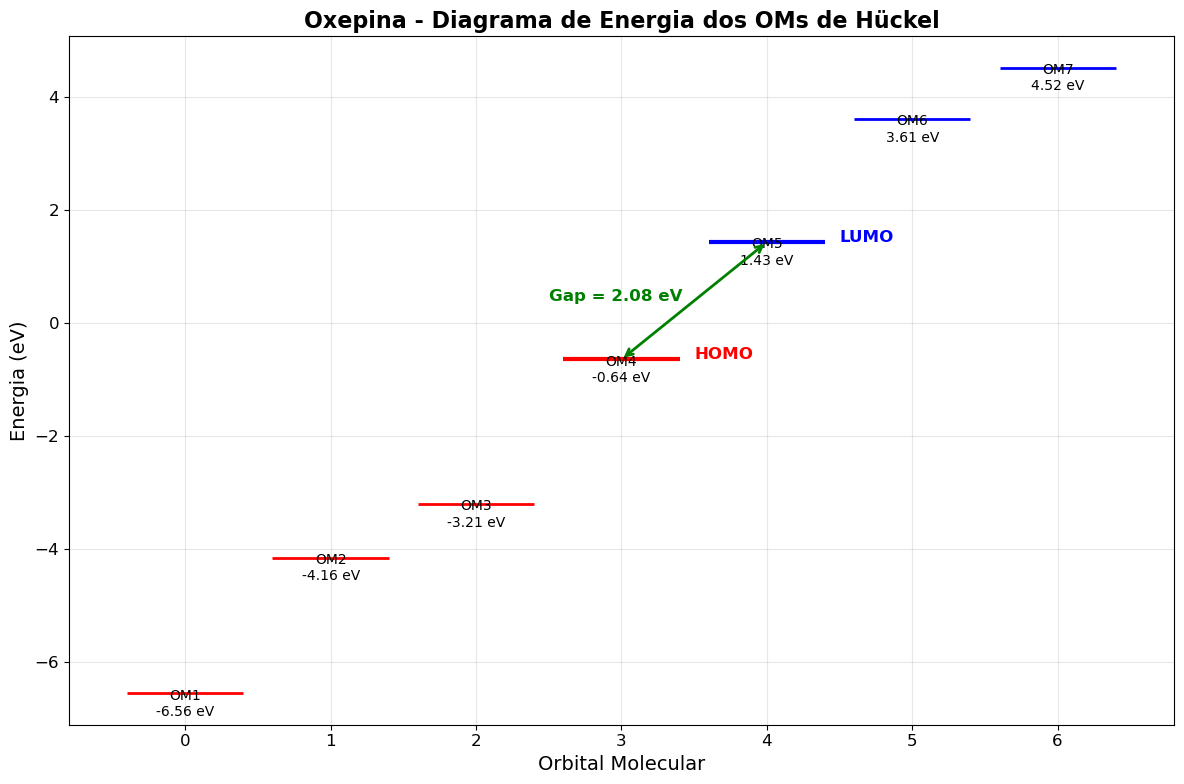

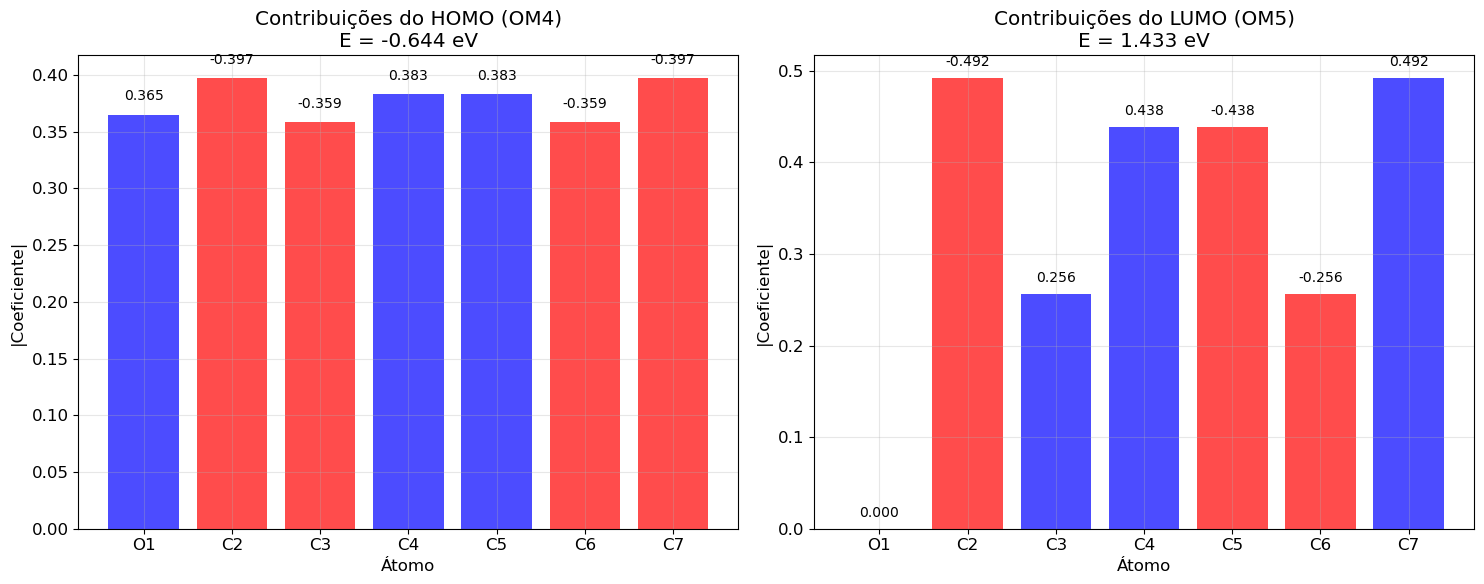

In [2]:
def plot_mo_diagram(analyzer):
    """Cria o diagrama de níveis de energia dos OMs"""
    r = analyzer.results
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plota os níveis de energia
    for i, E in enumerate(r['energies']):
        color = 'red' if i < r['n_occ'] else 'blue'
        linewidth = 3 if i in [r['homo_idx'], r['lumo_idx']] else 2
        
        ax.hlines(E, i-0.4, i+0.4, colors=color, linewidth=linewidth)
        
        # Rótulos
        if i == r['homo_idx']:
            ax.text(i+0.5, E, 'HOMO', fontsize=12, fontweight='bold', color='red')
        elif i == r['lumo_idx']:
            ax.text(i+0.5, E, 'LUMO', fontsize=12, fontweight='bold', color='blue')
        
        # Número do OM e energia
        ax.text(i, E-0.4, f"OM{i+1}\n{E:.2f} eV", ha='center', fontsize=10)
    
    # Formatação
    ax.set_xlim(-0.8, len(r['energies'])-0.2)
    ax.set_ylabel('Energia (eV)', fontsize=14)
    ax.set_xlabel('Orbital Molecular', fontsize=14)
    ax.set_title('Oxepina - Diagrama de Energia dos OMs de Hückel', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Adiciona a anotação do gap
    if r['gap']:
        ax.annotate('', xy=(r['lumo_idx'], r['lumo_energy']), 
                   xytext=(r['homo_idx'], r['homo_energy']),
                   arrowprops=dict(arrowstyle='<->', color='green', lw=2))
        ax.text((r['homo_idx'] + r['lumo_idx'])/2 - 1, 
               (r['homo_energy'] + r['lumo_energy'])/2,
               f'Gap = {r["gap"]:.2f} eV', 
               fontsize=12, color='green', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_orbital_contributions(analyzer):
    """Plota as contribuições dos orbitais HOMO e LUMO"""
    r = analyzer.results
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Contribuições do HOMO
    homo_coeffs = r['coefficients'][:, r['homo_idx']]
    atoms = [f"{analyzer.elements[i]}{i+1}" for i in range(analyzer.n_atoms)]
    
    colors = ['red' if c < 0 else 'blue' for c in homo_coeffs]
    bars1 = ax1.bar(atoms, np.abs(homo_coeffs), color=colors, alpha=0.7)
    ax1.set_title(f'Contribuições do HOMO (OM{r["homo_idx"]+1})\nE = {r["homo_energy"]:.3f} eV')
    ax1.set_ylabel('|Coeficiente|')
    ax1.set_xlabel('Átomo')
    ax1.grid(True, alpha=0.3)
    
    # Adiciona os valores dos coeficientes
    for bar, coeff in zip(bars1, homo_coeffs):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{coeff:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Contribuições do LUMO
    if r['lumo_idx'] < len(r['energies']):
        lumo_coeffs = r['coefficients'][:, r['lumo_idx']]
        colors = ['red' if c < 0 else 'blue' for c in lumo_coeffs]
        bars2 = ax2.bar(atoms, np.abs(lumo_coeffs), color=colors, alpha=0.7)
        ax2.set_title(f'Contribuições do LUMO (OM{r["lumo_idx"]+1})\nE = {r["lumo_energy"]:.3f} eV')
        ax2.set_ylabel('|Coeficiente|')
        ax2.set_xlabel('Átomo')
        ax2.grid(True, alpha=0.3)
        
        # Adiciona os valores dos coeficientes
        for bar, coeff in zip(bars2, lumo_coeffs):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{coeff:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Gera as visualizações
plot_mo_diagram(analyzer)
plot_orbital_contributions(analyzer)

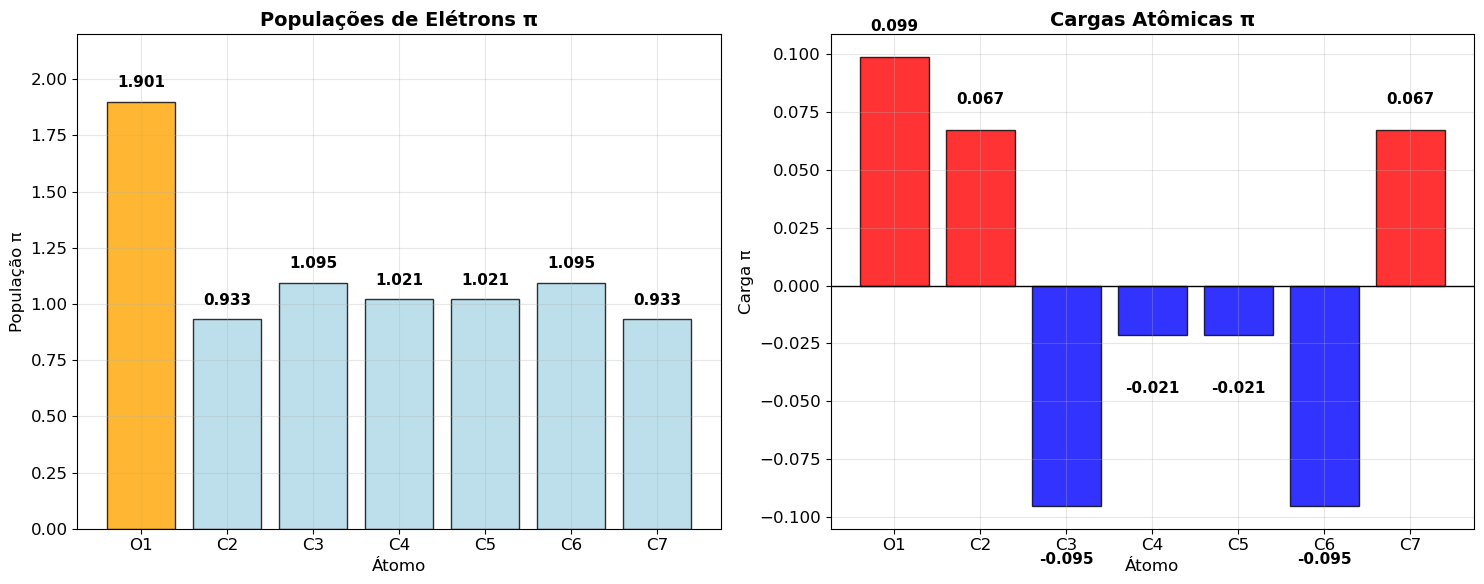

In [3]:
analyzer.plot_populations_and_charges()

In [5]:
# Exportação de dados aprimorada
r = analyzer.results
export_data = {
    'molecule': 'Oxepine',
    'formula': 'C6H6O',
    'pubchem_cid': 6451477,
    'smiles': 'C1=CC=COC=C1',
    'analysis_date': '2025-08-20',
    'method': 'Huckel_Method',
    'parameters': {
        'alpha_0': analyzer.alpha_0,
        'beta_0': analyzer.beta_0,
        'h_O': analyzer.h_O,
        'h_C': analyzer.h_C,
        'k_CO': analyzer.k_CO,
        'k_CC_single': analyzer.k_CC_single,
        'k_CC_double': analyzer.k_CC_double
    },
    'structure': {
        'n_atoms': analyzer.n_atoms,
        'n_electrons': analyzer.n_electrons,
        'elements': analyzer.elements,
        'bonds': [(i+1, j+1, k) for i, j, k in analyzer.bonds]  # Converte para base 1
    },
    'results': {
        'mo_energies_eV': r['energies'].tolist(),
        'homo_energy_eV': float(r['homo_energy']),
        'lumo_energy_eV': float(r['lumo_energy']),
        'homo_lumo_gap_eV': float(r['gap']),
        'homo_index': int(r['homo_idx']),
        'lumo_index': int(r['lumo_idx']),
        'pi_populations': r['populations'].tolist(),
        'pi_charges': r['charges'],  # Já é uma lista
        'bond_orders': {f"{k[0]}-{k[1]}": float(v) for k, v in r['bond_orders'].items()}
    },
    'interpretation': {
        'aromaticity': 'não-aromático',
        'electron_count': '8 (4n, n=2)',
        'ring_size': 'anel de 7 membros',
        'bond_pattern': 'alternado',
        'most_nucleophilic_sites': ['C2', 'C7'],
        'most_electrophilic_sites': ['C7', 'C2', 'C5'],
        'most_positive_charge': 'O1 (+0.099)',
        'most_negative_charge': 'C3, C6 (-0.095)'
    },
    'validation': {
        'electron_conservation': sum(r['populations']),
        'charge_conservation': sum(r['charges']),
        'density_matrix_symmetric': True,
        'hamiltonian_symmetric': True
    }
}

# Salva em arquivo JSON
with open('oxepine_huckel_data.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("✓ Dados exportados para oxepine_huckel_data.json")

print("\n" + "="*60)
print("ANÁLISE DE HÜCKEL DA OXEPINA - CONCLUÍDA")
print("="*60)

print("\n### RESUMO DOS RESULTADOS ###")
print(f"Molécula: Oxepina (C₆H₆O)")
print(f"Método: Aproximação de Hückel para elétrons π")
print(f"Total de elétrons π: {analyzer.n_electrons}")
print(f"Energia do HOMO: {r['homo_energy']:.3f} eV")
print(f"Energia do LUMO: {r['lumo_energy']:.3f} eV") 
print(f"Gap HOMO-LUMO: {r['gap']:.3f} eV")
print(f"Caráter eletrônico: Não-aromático (8π, ligações alternadas)")

print("\n### PRINCIPAIS CONCLUSÕES ###")
print("• A oxepina é não-aromática com 8 elétrons π (regra 4n)")
print("• O oxigênio atua como um heteroátomo retirador de elétrons (carga +0.099)")
print("• As ligações C-O são fracas (ordem de ligação π ~0.21)")
print("• As ligações duplas C=C exibem ordens de ligação π mais altas (~0.87-0.90)")
print("• O padrão de ligações alternadas indica um sistema π localizado")
print("• Sítios mais reativos: C2, C7 (adjacentes ao oxigênio)")

✓ Dados exportados para oxepine_huckel_data.json

ANÁLISE DE HÜCKEL DA OXEPINA - CONCLUÍDA

### RESUMO DOS RESULTADOS ###
Molécula: Oxepina (C₆H₆O)
Método: Aproximação de Hückel para elétrons π
Total de elétrons π: 8
Energia do HOMO: -0.644 eV
Energia do LUMO: 1.433 eV
Gap HOMO-LUMO: 2.077 eV
Caráter eletrônico: Não-aromático (8π, ligações alternadas)

### PRINCIPAIS CONCLUSÕES ###
• A oxepina é não-aromática com 8 elétrons π (regra 4n)
• O oxigênio atua como um heteroátomo retirador de elétrons (carga +0.099)
• As ligações C-O são fracas (ordem de ligação π ~0.21)
• As ligações duplas C=C exibem ordens de ligação π mais altas (~0.87-0.90)
• O padrão de ligações alternadas indica um sistema π localizado
• Sítios mais reativos: C2, C7 (adjacentes ao oxigênio)
